In [1]:
import os,sys
import numpy as np
import copy

codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import nsd_utils, default_paths, coco_utils
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
from model_fitting import initialize_fitting
from plotting_and_analysis import plot_utils 

In [3]:
subject = 1;
fn2load = os.path.join(default_paths.sketch_token_feat_path, 'LDA','S%d_LDA.npy'%subject)
pc_result = np.load(fn2load, allow_pickle=True).item()

scores_each_prf = pc_result['scores']
wts_each_prf = pc_result['wts']
trn_acc_each_prf = pc_result['trn_acc']

In [4]:
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)  
n_prfs = models.shape[0]

most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [5]:
np.where((np.round(models[:,0],2)==0.00) & (np.round(models[:,1],2)==0.00))
mm = 866
models[mm]

array([0.        , 0.        , 0.28787428])

In [6]:
# Gather semantic labels for the images (COCO super-categories)
coco_trn, coco_val = coco_utils.init_coco()
cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = coco_utils.get_coco_cat_info(coco_val)
subject_df = nsd_utils.get_subj_df(subject);
all_coco_ids = np.array(subject_df['cocoId'])
ims_each_supcat = []
for sc, scname in enumerate(supcat_names):
    ims_in_supcat = coco_utils.get_ims_in_supcat(coco_trn, coco_val, scname, all_coco_ids)
    ims_each_supcat.append(ims_in_supcat)
ims_each_supcat = np.array(ims_each_supcat)
supcats_each_image = [np.where(ims_each_supcat[:,ii])[0] for ii in range(ims_each_supcat.shape[1])]

# For now, choosing just the images which have only one super-category present.
ims_to_use = [sc for sc in range(len(supcats_each_image)) if len(supcats_each_image[sc])==1]
supcat_labels = np.array([supcats_each_image[sc] for sc in ims_to_use])
n_each_supcat = [np.sum(supcat_labels==sc) for sc in np.unique(supcat_labels)]
print('\nProportion data labels each super-cat:')
print(supcat_names)
print(n_each_supcat)
print(np.sum(n_each_supcat))

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
loading annotations into memory...
Done (t=16.00s)
creating index...
index created!

Proportion data labels each super-cat:
['animal', 'sports', 'person', 'vehicle', 'indoor', 'furniture', 'kitchen', 'outdoor', 'appliance', 'electronic', 'food', 'accessory']
[1103, 31, 41, 560, 249, 179, 16, 206, 87, 61, 258, 37]
2828


In [8]:
supcat_names

['accessory',
 'animal',
 'appliance',
 'electronic',
 'food',
 'furniture',
 'indoor',
 'kitchen',
 'outdoor',
 'person',
 'sports',
 'vehicle']

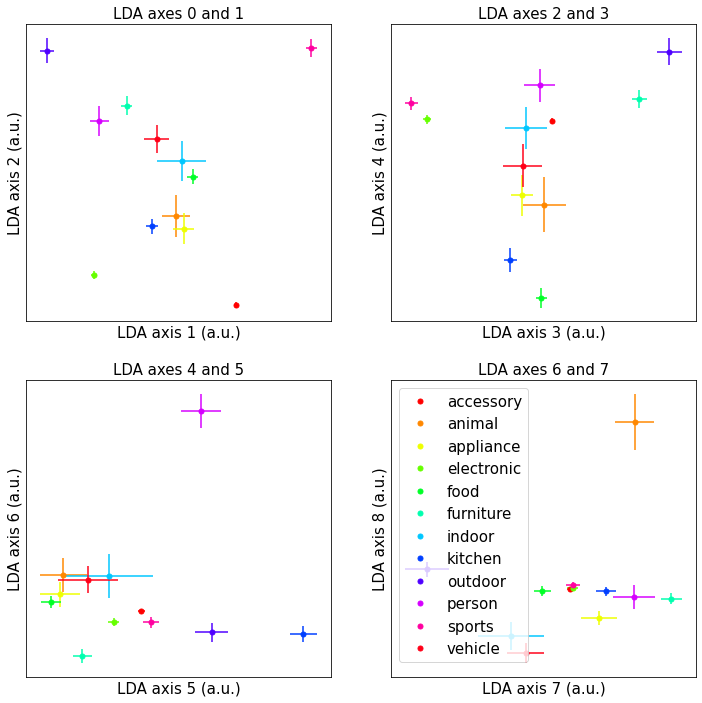

In [11]:
mm = 866

scores = scores_each_prf[mm]

plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(12,12));

ax2plot_list = [[0,1], [2,3], [4,5], [6,7]]

# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))
colors = cm.hsv(np.linspace(0,1,len(supcat_names)))

for ai, ax2plot in enumerate(ax2plot_list):
    plt.subplot(2,2,ai+1)
    
    lh=[]
    for sc, scname in enumerate(supcat_names):

        ims_in_supcat = (supcat_labels==sc)[:,0]
        meanvals = np.mean(scores[ims_in_supcat,:], axis=0)
        semvals = np.std(scores[ims_in_supcat,:], axis=0)/np.sqrt(np.sum(ims_in_supcat))

#         plt.plot(scores_trf[ims_in_supcat,ax2plot[0]], \
#                  scores_trf[ims_in_supcat,ax2plot[1]],'.',alpha=0.5,color=colors[sc])

        h, = plt.plot(meanvals[ax2plot[0]], meanvals[ax2plot[1]],'.',markersize=10,color=colors[sc])
        plt.errorbar(x = meanvals[ax2plot[0]], y = meanvals[ax2plot[1]], \
                     yerr = semvals[ax2plot[1]], xerr = semvals[ax2plot[0]], color=colors[sc])
        lh.append(h)

    if ai==3:
        plt.legend(handles=lh,labels=supcat_names)
    
    plt.xlabel('LDA axis %d (a.u.)'%(ax2plot[0]+1))
    plt.ylabel('LDA axis %d (a.u.)'%(ax2plot[1]+1))

    plt.xticks([])
    plt.yticks([])

    # plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
    #       %(models[mm,0], models[mm,1], models[mm,2]));

    plt.title('LDA axes %d and %d'%(ax2plot[0], ax2plot[1]));



In [15]:
scores_each_prf[0].shape

(2828, 11)

Text(0.5, 0.98, 'LDA scalings from sketch tokens model, all features\n')

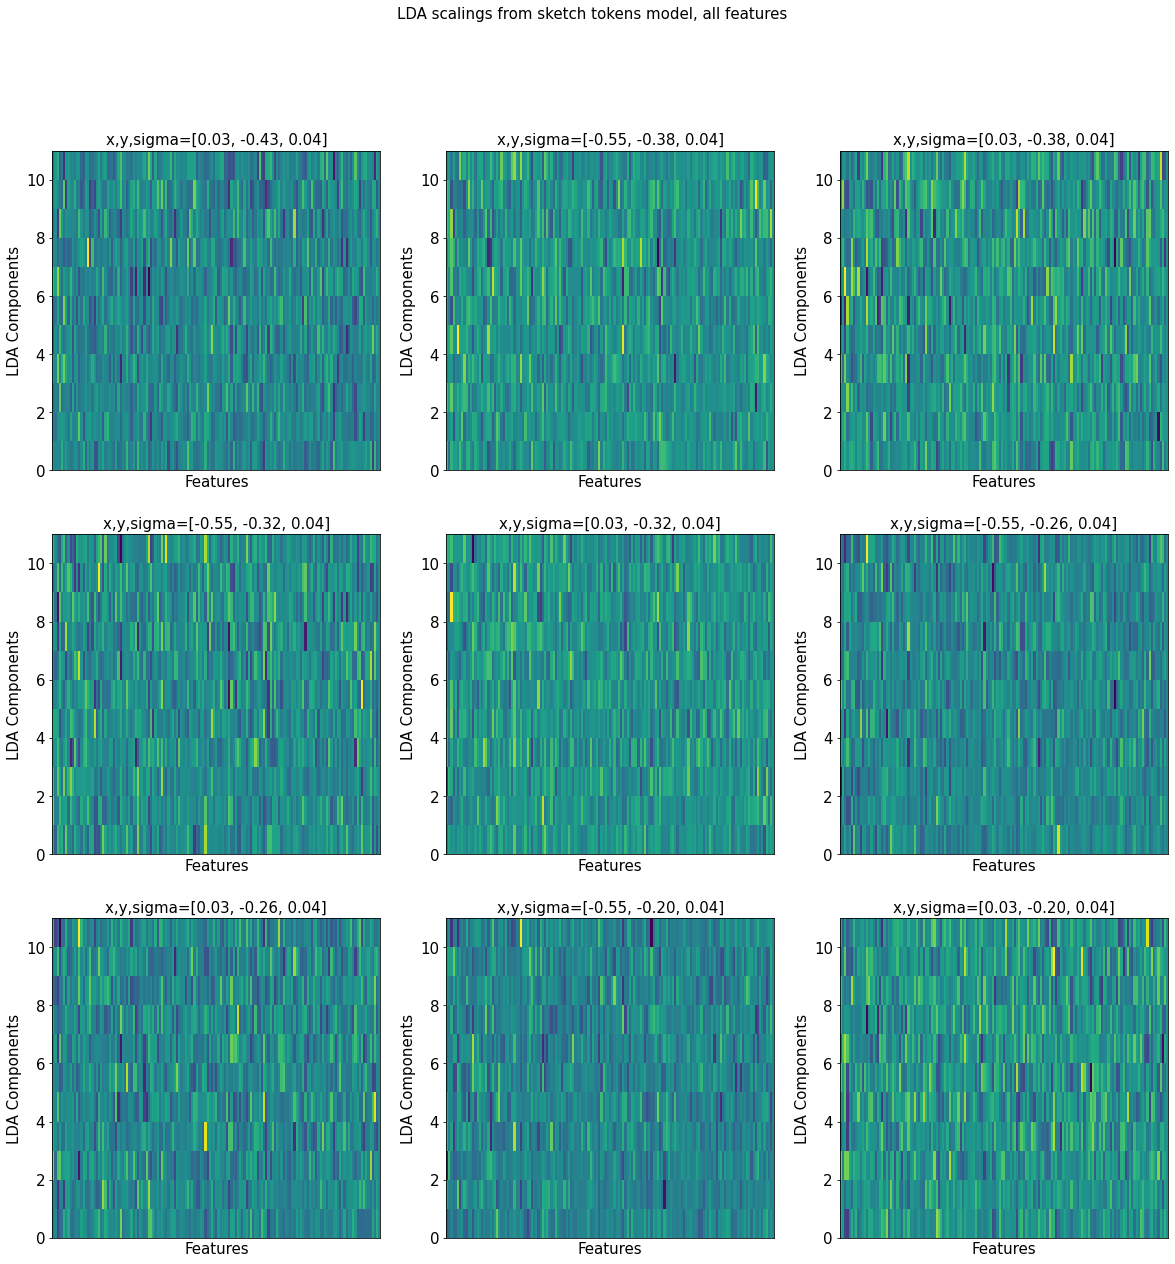

In [13]:
plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(20,20));

# pcs2plot = [0,1]
# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))

mm2plot = np.arange(50,140,10)
npx = int(np.ceil(np.sqrt(len(mm2plot))))
npy = int(np.ceil(len(mm2plot)/npx))

for mi, mm in enumerate(mm2plot):
    wts = wts_each_prf[mm].T
    # wts is components x features
    plt.subplot(npx,npy,mi+1)
    
    plt.pcolormesh(wts)
    
#     if mi==len(mm2plot)-npx:
#         plt.xlabel('PC %d (a.u.)'%(pcs2plot[0]+1))
#         plt.ylabel('PC %d (a.u.)'%(pcs2plot[1]+1))
    
    plt.xticks([])
#     plt.yticks([])
    
    plt.ylabel('LDA Components')
    plt.xlabel('Features')
    
    plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
          %(models[mm,0], models[mm,1], models[mm,2]));
    
plt.suptitle('LDA scalings from sketch tokens model, all features\n')
    

Text(0.5, 0.98, 'Comparing LDA scalings across models: colors are pRF models')

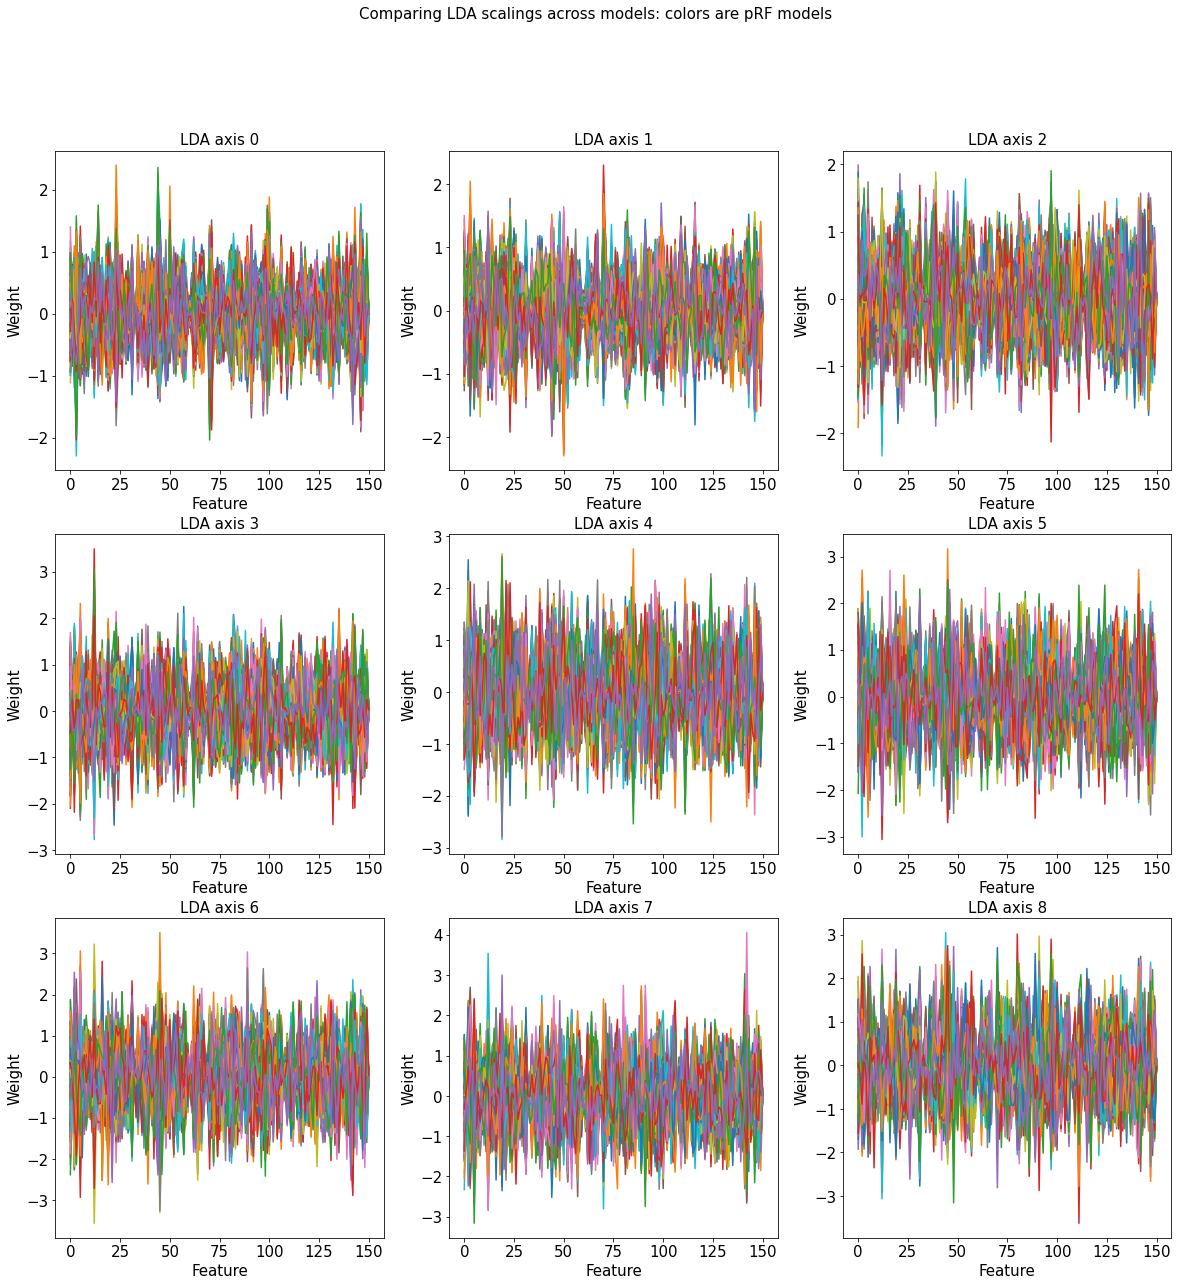

In [14]:
plt.figure(figsize=(20,20));

npx=3;npy=3
for pc in range(9):
    plt.subplot(npx,npy,pc+1)
    w2plot = np.array([wts_each_prf[mm][:,pc] for mm in range(n_prfs)])
    plt.plot(w2plot.T);
    plt.title('LDA axis %d'%pc)
    plt.xlabel('Feature')
    plt.ylabel('Weight')
    
plt.suptitle('Comparing LDA scalings across models: colors are pRF models')

In [16]:
from scipy.io import loadmat
cluster_fn = os.path.join('/user_data/mmhender/toolboxes/SketchTokens/', 'clusters.mat')
clust = loadmat(cluster_fn)
clusters = clust['clusters']['clusters'][0][0]

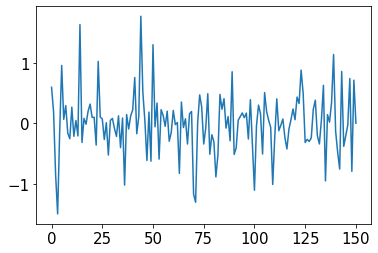

In [26]:
plt.figure();
plt.plot(wts_each_prf[mm][:,pc])

Text(0.5, 0.98, 'Sketch token features with lowest weights for LDA axis 2')

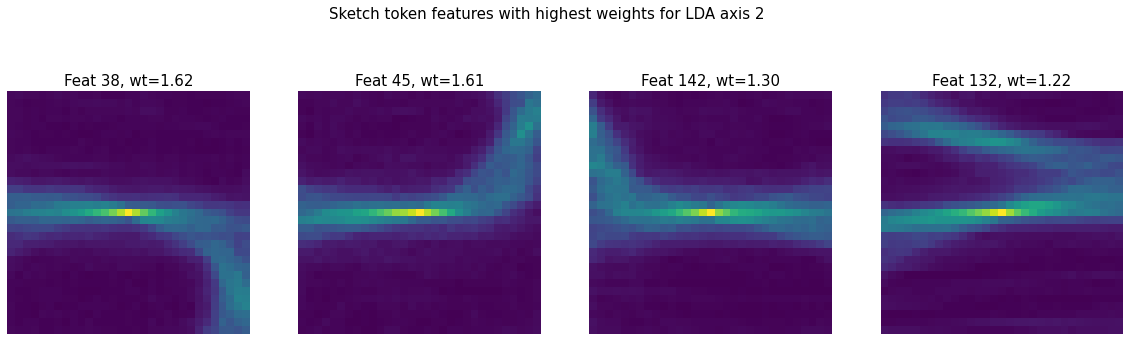

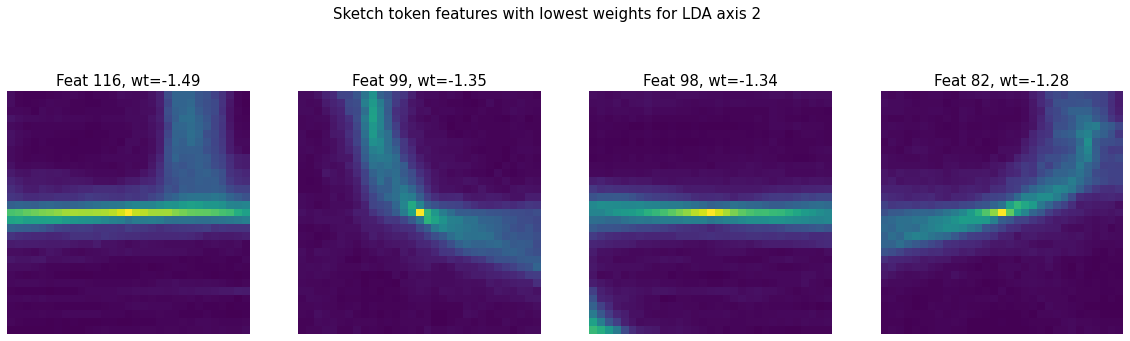

In [29]:
nclusters = clusters.shape[2]
n2plot = 4
# clusters2plot = np.random.choice(np.arange(0,nclusters), n2plot,replace=False)
pc=2
mm=866
# w = np.array([wts_each_prf[mm][pc,:] for mm in range(n_prfs)])
# wmean = np.mean(w, axis=0)
w = wts_each_prf[mm][:,pc]

clusters2plot = np.flip(np.argsort(w))[0:n2plot]

plt.figure(figsize=(20,6))
for ci,cc in enumerate(clusters2plot):
    
    plt.subplot(1,4,ci+1)
    plt.pcolormesh(clusters[:,:,cc])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title('Feat %d, wt=%.2f'%(cc, w[cc]))
    
plt.suptitle('Sketch token features with highest weights for LDA axis %d'%pc)

clusters2plot = np.argsort(w)[0:n2plot]

plt.figure(figsize=(20,6))
for ci,cc in enumerate(clusters2plot):
    
    plt.subplot(1,4,ci+1)
    plt.pcolormesh(clusters[:,:,cc])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title('Feat %d, wt=%.2f'%(cc, w[cc]))
    
plt.suptitle('Sketch token features with lowest weights for LDA axis %d'%pc)